In [1]:
WORKSPACE_PATH = 'workspace'
ANNOTATION_PATH = WORKSPACE_PATH+'/annotations'
IMAGE_PATH = WORKSPACE_PATH+'/images'
MODEL_PATH = WORKSPACE_PATH+'/models'

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2

Lade JSON

In [3]:
import json

def json_read(data_path):
    with open(data_path, 'r') as data:
        data = json.load(data)
    return data

In [4]:
JSON_NAME = '/instances_default.json'
DATA_PATH = ANNOTATION_PATH+'/original'+ JSON_NAME
data = json_read(DATA_PATH)

Bennene Bilder im Verzeichnis images und in der Annotationsdatei um

In [5]:
import os

def rename_images(IMAGE_PATH):
    index=1
    img  = os.listdir(IMAGE_PATH)
    for i in img:
        new_name = f"{index:012d}"+'.jpeg'
        old_path = os.path.join(IMAGE_PATH, i)
        new_path = os.path.join(IMAGE_PATH, new_name)
        os.rename(old_path, new_path)
        index += 1

def rename_images_in_annotation():
    index=1
    for img in data['images']:
        new_name = f"{index:012d}"+'.jpeg'
        img['file_name'] = new_name 
        index += 1

rename_images(IMAGE_PATH+'/original')
rename_images_in_annotation()

with open(ANNOTATION_PATH+'/original' + JSON_NAME, 'w') as destination_file:
    json.dump(data, destination_file, indent=2)  

In [6]:
images = []
bounding_boxes = []
labels = []
image_height = 1366
image_width = 768

for image in data['images']:
    one_image = []
    one_image.append(image['id'])
    one_image.append(image['file_name'])
    images.append(one_image)

for annotation in data['annotations']:
    one_box = []
    box_and_id = []
    one_box.append(annotation['bbox'])
    bounding_boxes.append(one_box)

Resize

In [7]:
def resize_imgaes(input_path, output_path, height, width):
    image =  cv2.imread(input_path)
    resized_image = cv2.resize(image, (width, height))
    cv2.imwrite(output_path, resized_image)    

def resize_bounding_boxes_and_area(input_path,bounding_boxes, height, width):
    image =  cv2.imread(input_path)
    height_ratio = height / image.shape[0]
    width_ratio = width / image.shape[1]
    
    for box in bounding_boxes:
        resized_boxes = []
        resized_area = 0

        x = np.round(box[0]*width_ratio,2)
        y = np.round(box[1]*height_ratio,2)
        x_width = np.round(box[2]*width_ratio,2)
        y_height = np.round(box[3]*height_ratio,2)
        resized_boxes.append([x, y, x_width, y_height])

        resized_area = x_width * y_height

    return x, y, x_width, y_height, resized_area


In [8]:
import os

new_height = 640
new_width = 640
OUTPUT_PATH_IMAGES = IMAGE_PATH + '/' + str(new_height) + 'x' + str(new_width)
OUTPUTPATH_ANNOTATIONS = ANNOTATION_PATH + '/' + str(new_height) + 'x' + str(new_width)

os.makedirs(OUTPUT_PATH_IMAGES, exist_ok=True)
os.makedirs(OUTPUTPATH_ANNOTATIONS, exist_ok=True)

#Copy JSON Doc in new ANNOTATIONPATH
with open(DATA_PATH, 'r') as source_file:
    data = json.load(source_file)
with open(OUTPUTPATH_ANNOTATIONS + JSON_NAME, 'w') as destination_file:
    json.dump(data, destination_file, indent=2)    


In [9]:
#Resize Images
for img in range(len(images)):
    resize_imgaes(IMAGE_PATH+'/original'+ '/' +images[img][1], OUTPUT_PATH_IMAGES+ '/' +images[img][1], new_height, new_width)


with open(OUTPUTPATH_ANNOTATIONS + JSON_NAME, 'r') as json_data:
    data = json.load(json_data)


#Resize BBox and area
for i, annotation in enumerate(data['annotations']):
    calculate_resize = resize_bounding_boxes_and_area(IMAGE_PATH+'/original'+ '/' +images[0][1],bounding_boxes[i], new_height, new_width)
    new_box = calculate_resize[0],calculate_resize[1],calculate_resize[2],calculate_resize[3]
    new_area = calculate_resize[4]
    annotation['bbox'] = new_box
    annotation['area'] = new_area

#Change height/width
for image in data['images']:
    image['height']=new_height
    image['width']=new_width

with open(OUTPUTPATH_ANNOTATIONS + JSON_NAME, 'w') as destination_file:
    json.dump(data, destination_file, indent=2)    

Create Dataset

In [10]:
import json

images = data['images']
annotations = data['annotations']
categories = data['categories']

dataset = []

for annotation in annotations:
    image_info = next(image for image in images if image['id'] == annotation['image_id'])
    image_path = OUTPUT_PATH_IMAGES + '/'+ image_info['file_name']
    bbox = annotation['bbox']  # [x, y, width, height]
    class_id = annotation['category_id']

    xmin, ymin, width, height = bbox
    #xmax, ymax = xmin + width, ymin + height

    dataset.append({
        'image_path': image_path,
        'bbox': [xmin, ymin, width, height],
        'class_id': class_id
    })

print('Annotation',len(dataset))
da =dataset[0]
print(dataset[0])
print(da['image_path'])


Annotation 697
{'image_path': 'workspace/images/640x640/000000000001.jpeg', 'bbox': [32.81, 171.74, 401.16, 142.67], 'class_id': 1}
workspace/images/640x640/000000000001.jpeg


In [11]:
import os

def get_file_list(directory):
    file_list = []
    for filename in os.listdir(directory):
        full_path = os.path.join(directory, filename)
        normalized_path = os.path.normpath(full_path)
        normalized_path = normalized_path.replace(os.path.sep, '/')
        if os.path.isfile(normalized_path):
            file_list.append(normalized_path)
    return file_list

In [12]:

def convert_annotations_to_array(coco_data, num_classes=41):
    annotations = coco_data['annotations']
    num_annotations = len(annotations)

    # Initialize empty arrays for bounding boxes and labels
    bounding_boxes = np.zeros((num_annotations, 4), dtype=np.float32)
    labels = np.zeros((num_annotations,), dtype=np.int32)

    for i, annotation in enumerate(annotations):
        # Extract bounding box coordinates
        bbox = annotation['bbox']
        bounding_boxes[i] = np.array([bbox[0], bbox[1], bbox[2], bbox[3]], dtype=np.float32)

        # Extract class label
        labels[i] = annotation['category_id']

    return bounding_boxes, labels


bounding_boxes, labels = convert_annotations_to_array(data)

#bbox_data = np.random.random((41, bounding_boxes))

trainTargets = {
    "class_label": labels,
    "bounding_box": bounding_boxes
}
print(bounding_boxes.shape)
"""
testTargets = {
    "class_label": testLabels,
    "bounding_box": testBBoxes
}
"""

(697, 4)


'\ntestTargets = {\n    "class_label": testLabels,\n    "bounding_box": testBBoxes\n}\n'

In [13]:
directory_path = OUTPUT_PATH_IMAGES
files = get_file_list(directory_path)


bbox_list=[]
class_id_list=[]
image_path_list=[]

for k in files:
    ann_bbox=[]
    ann_class_id=[]
    for i in dataset:
        d = i
        if d['image_path'] == k:
            ann_bbox.append(d['bbox'])
            #ann_bbox.append(d['class_id'])
            ann_class_id.append(d['class_id'])
    
    image = cv2.imread(d['image_path'])
    image = image / 255.0 

        
    bbox_list.append(ann_bbox)
    class_id_list.append(ann_class_id)
    image_path_list.append(image)

images_data = np.array(image_path_list)
bounding_boxes = np.array(bbox_list)
class_labels = np.array(class_id_list)

print(images_data.shape)
print(bounding_boxes.shape)
print(class_labels.shape)
print(dataset[677])



(17, 640, 640, 3)
(17, 41, 4)
(17, 41)
{'image_path': 'workspace/images/640x640/000000000017.jpeg', 'bbox': [29.68, 511.61, 401.98, 101.88], 'class_id': 32}


In [14]:
class_ids = []

for cat in data['categories']:
    class_name = cat['name']
    class_ids.append(class_name)
class_mapping = dict(zip(range(len(class_ids)), class_ids))
print(len(class_ids))

42


In [15]:
import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

Using TensorFlow backend


Yolo

In [16]:
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0


In [17]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco",  # We will use yolov8 small backbone with coco weights
    input_shape=(new_width, new_height, 3),
)
#Freeze base model
#base_model.trainable = False

In [19]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xywh",
    backbone=backbone,
    fpn_depth=1,
)


In [20]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou")
yolo.summary()

Model: "yolov8_detector_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 640, 640, 3)]        0         []                            


                                                                                                  
 model_1 (Functional)        {'P3': (None, 80, 80, 128)   5089760   ['input_3[0][0]']             
                             , 'P4': (None, 40, 40, 256                                           
                             ),                                                                   
                              'P5': (None, 20, 20, 512)                                           
                             }                                                                    
                                                                                                  
 tf.repeat_4 (TFOpLambda)    (None, 40, 20, 512)          0         ['model_1[0][2]']             
                                                                                                  
 tf.repeat_5 (TFOpLambda)    (None, 40, 40, 512)          0         ['tf.repeat_4[0][0]']         
          

In [21]:
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss',  
                               patience=3,          
                               restore_best_weights=True)  

callbacks = [early_stopping]

history = yolo.fit(
    images_data, 
    {"classes": class_labels,"boxes": bounding_boxes},
    epochs=66,
    callbacks=early_stopping,
    #callbacks=[EvaluateCOCOMetricsCallback(val_ds, "model.h5")],
)

Epoch 1/66


1/1 [==============================] - 33s 33s/step - loss: 111.6842 - box_loss: 6.0082 - class_loss: 105.6760
Epoch 2/66
1/1 [==============================] - 7s 7s/step - loss: 106.8814 - box_loss: 5.9474 - class_loss: 100.9341
Epoch 3/66
1/1 [==============================] - 7s 7s/step - loss: 90.4355 - box_loss: 5.5994 - class_loss: 84.8360
Epoch 4/66
1/1 [==============================] - 7s 7s/step - loss: 80.1925 - box_loss: 5.3532 - class_loss: 74.8393
Epoch 5/66
1/1 [==============================] - 7s 7s/step - loss: 71.4457 - box_loss: 5.0550 - class_loss: 66.3907
Epoch 6/66
1/1 [==============================] - 7s 7s/step - loss: 55.0756 - box_loss: 4.3852 - class_loss: 50.6904
Epoch 7/66
1/1 [==============================] - 7s 7s/step - loss: 47.0303 - box_loss: 3.9712 - class_loss: 43.0592
Epoch 8/66
1/1 [==============================] - 7s 7s/step - loss: 46.7487 - box_loss: 4.0853 - class_loss: 42.6634
Epoch 9/66
1/1 [==============================] 

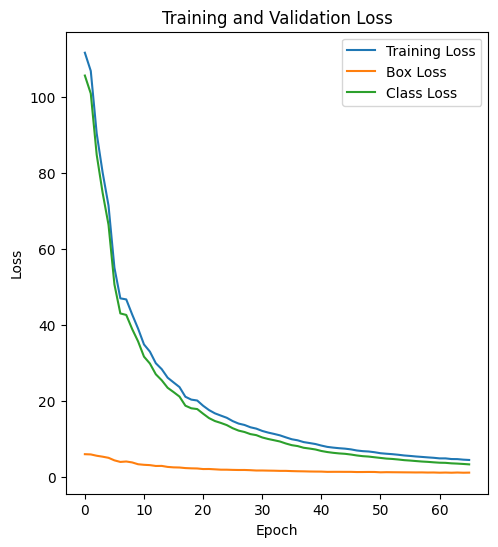

In [22]:
def plot_metrics(history):
    # Plot training loss
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['box_loss'], label='Box Loss')
    plt.plot(history.history['class_loss'], label='Class Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    if 'accuracy' in history.history:
        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Training and Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.show()
plot_metrics(history)


In [23]:
from keras.preprocessing import image as keras_image

img = OUTPUT_PATH_IMAGES + '/000000000001.jpeg'
img = keras_image.load_img(img, target_size=(new_height, new_width))
img_array = keras_image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

predictions = yolo.predict(img_array)
predicted_classes =np.array(predictions['classes'])
predicted_boxes =np.array(predictions['boxes'])
predicted_confidence = np.array(predictions['confidence'])

1/1 [==============================] - 4s 4s/step


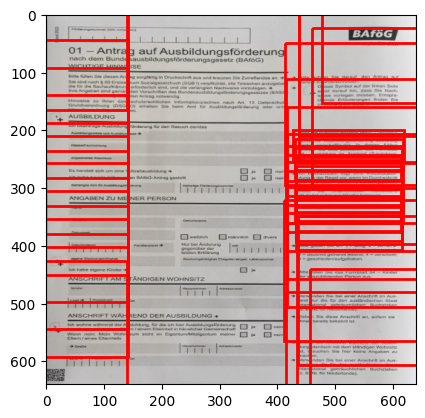

In [29]:
import matplotlib.patches as patches

def plot_bounding_boxes(boxes, image_path):
    img = plt.imread(image_path)
    fig, ax = plt.subplots(1)
    ax.imshow(img)
    for box in boxes:
        x, y, w, h = box
        rect = patches.Rectangle(
            (x, y), w, h, linewidth=2, edgecolor='r', facecolor='none'
        )
        ax.add_patch(rect)
    plt.show()


image_path = OUTPUT_PATH_IMAGES + '/000000000001.jpeg'

predicted_boxes_array = predicted_boxes.reshape(-1, 4)
sliced_array = predicted_boxes_array[:40]
plot_bounding_boxes(sliced_array, image_path)


Transfer Learning

In [ ]:
""""
base_model = keras_cv.models.MobileNetV3Backbone.from_preset(
    "mobilenet_v3_large_imagenet",
    load_weights=False,
)
#Freeze base model
base_model.trainable = False
"""

In [ ]:
"""
import keras

inputs = keras.Input(shape=(new_height, new_width, 3))
x = base_model(inputs, training=False)
x = keras.layers.GlobalAveragePooling2D()(x)

class_id_output = keras.layers.Dense(41, activation='softmax', name='class_id')(x)

bbox_output = keras.layers.Dense(4, name='bbox')(x)
model = keras.Model(inputs, [class_id_output, bbox_output]) 

model.compile(
    optimizer=keras.optimizers.Adam(),
    loss={'class_id': 'sparse_categorical_crossentropy', 'bbox': 'mean_squared_error'},#Regression für bbox
    metrics={'class_id': 'accuracy'}
)

#model.fit(images_data,  {"class_id": class_labels,"bbox": bounding_boxes}, epochs=20, validation_split=0.2)

#model.summary()
"""

NameError: name 'base_model' is not defined